# Logistic (Logit) Regression - Example 1
This code is an example of a logistic regression using a real world dataset from a (Portuguese) financial institution that can be downloaded here: (https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv).

Keep in mind that our dependent variable $y$ assumes the value of 1 if the client did subscribe a term deposit, or 0 otherwise. Our goal is to build a Logit model using this data to predict whether other clients will subscribe term deposits, according to some observables.

The code was reproduced from here: (https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8).



In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

\
<b>Importing and adjusting the data

In [2]:
data = pd.read_csv("bank.csv", header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
data["education"].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [5]:
#Grouping values 'basic.9y', 'basic.6y', and 'basic.4y' into one category, 'Basic', in the 'education' column
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [6]:
data["education"].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

Below, we have the full data description:

- age (numeric)
- job: type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
- marital: marital status (categorical: “divorced”, “married”, “single”, “unknown”)
- education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
- default: has credit in default? (categorical: “no”, “yes”, “unknown”)
- housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
- loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
- contact: contact communication type (categorical: “cellular”, “telephone”)
- month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
- day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
- emp.var.rate: employment variation rate — (numeric)
- cons.price.idx: consumer price index — (numeric)
- cons.conf.idx: consumer confidence index — (numeric)
- euribor3m: euribor 3 month rate — (numeric)
- nr.employed: number of employees — (numeric)

\
<b> Data Exploration

In [7]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

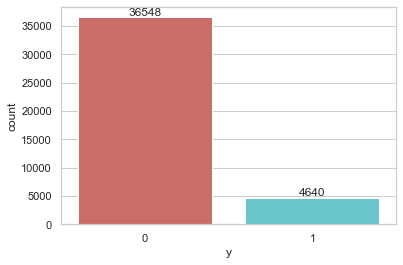

<Figure size 432x288 with 0 Axes>

In [8]:
g = sns.countplot(x=data['y'],data=data,palette='hls',order=data['y'].value_counts(ascending=False).index)
abs_values = data['y'].value_counts(ascending=False).values
g.bar_label(container=g.containers[0], labels=abs_values)
#sns.countplot(x='y', data=data, palette='hls')
plt.show()
#plt.savefig('count_plot')

In [9]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


In [10]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [11]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [12]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [13]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


\
<b> Data visualization

Text(0, 0.5, 'Frequency of Purchase')

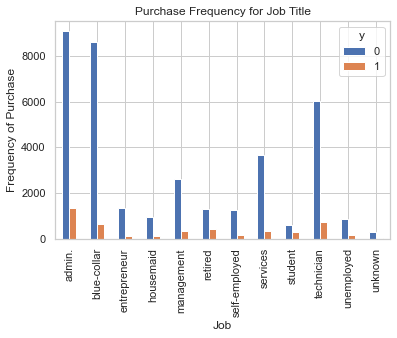

In [14]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
#plt.savefig('purchase_fre_job')

#we note that the job title is a good predictor for the dependent variable (high variation)

Text(0, 0.5, 'Proportion of Customers')

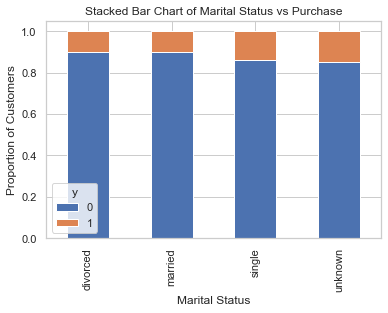

In [15]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
#plt.savefig('mariral_vs_pur_stack')

#marital status seems not to be a good predictor, the dependent variable doesn't vary too much among this category

Text(0, 0.5, 'Proportion of Customers')

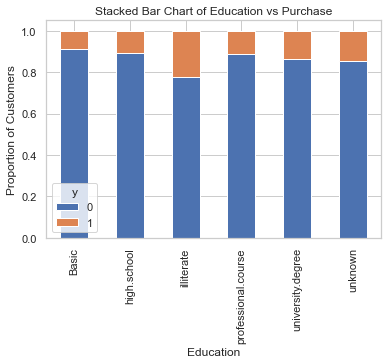

In [16]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
#plt.savefig('edu_vs_pur_stack')

#education seems to be a quite fine predictor

Text(0, 0.5, 'Frequency of Purchase')

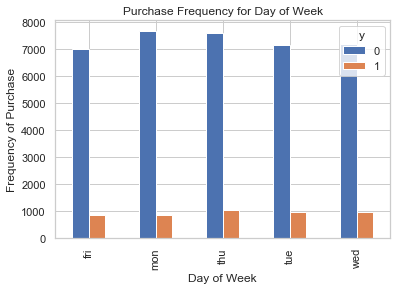

In [17]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
#plt.savefig('pur_dayofweek_bar')

#not a good predictor

Text(0, 0.5, 'Frequency of Purchase')

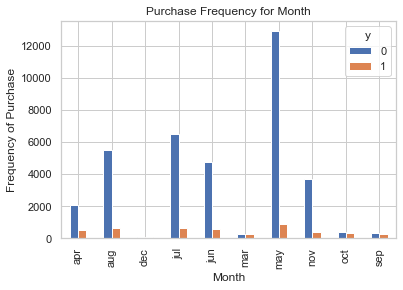

In [18]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
#plt.savefig('pur_fre_month_bar')

#month is a good predictor

Text(0, 0.5, 'Frequency')

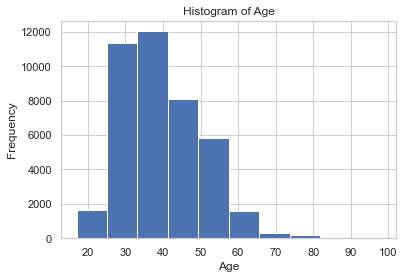

In [19]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
#plt.savefig('hist_age')

#age is a good predictor, most clients that did subscribe term deposits are in the age range of 30-40

Text(0, 0.5, 'Frequency of Purchase')

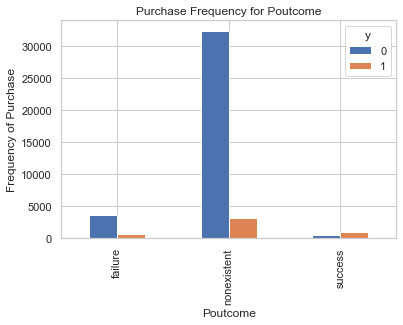

In [20]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
#plt.savefig('pur_fre_pout_bar')

#the outcome of the previous marketing campaign seems to be a good predictor

\
<b>Creation of dummy variables</b>

This is useful in category variables, since we will be changing the value of those columns from categorical (text) to boolean. For example, instead of 'marital', which may be ('divorced','married','single','unknown'), we now will have the following columns:
- marital_divorced
- marital_married
- marital_single
- marital_unknown

If we're looking to a married individual, then these columns will be valued as (0,1,0,0).\
For a better understanding of this step, see (https://www.sharpsightlabs.com/blog/pandas-get-dummies/).

In [21]:
#the point is to have dummy columns such that, instead of text values, we have 0's or 1's

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var #identifying the column of interest (one of the many in cat_vars) in this round. This is needed just to always reset this variable
    cat_list = pd.get_dummies(data[var], prefix=var) #magic happens here. Get dummies of one of the columns in cat_vars, and then sets the new column name as name-old-col_first-categ
    #print(cat_list) #you can uncomment this line and comment ALL OTHERS below to see what's happening before changing the data
    data1=data.join(cat_list) #sets a new dataset, which is the original merged with the new dummy columns
    data=data1 #assigns this new dataset to the original one, performing the change in the original dataset
    
#cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist() #creates a list of the columns in the dataset, including the new dummy ones
to_keep=[i for i in data_vars if i not in cat_vars] #creates a list with a for loop. This new list contains all columns in the changed dataset, but without the previous columns that generated this dummies (check the drop_first parameter in link above to get some intuition on why this is necessary)

In [22]:
#Finally, this new dataset, called 'data_final', is composed of all non-categorical columns (the ones ignored in the previous cell), and the dummy ones
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

<b>Over-sampling using SMOTE
    
Since our dataset is unbalanced (more subscription observations than no-subscription), we will use a technique called SMOTE, which may be better understood with this two references: (https://arxiv.org/pdf/1106.1813.pdf) and (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

Briefly, all we want is to increase the amount of no-subscription observation in our training data (not change the original dataset), in order to have an equal (or close) proportion of both types in our sample, and avoid predicting always 0 or always 1 just because we have lots of 0 or lots of 1 in the training data.

In [23]:
X = data_final.loc[:, data_final.columns != 'y'] #dataframe with all independent variables
y = data_final.loc[:, data_final.columns == 'y'] #dataframe with the outcome variable

print(X)
print(y)

       age  duration  campaign  pdays  previous  emp_var_rate  cons_price_idx  \
0       44       210         1    999         0           1.4          93.444   
1       53       138         1    999         0          -0.1          93.200   
2       28       339         3      6         2          -1.7          94.055   
3       39       185         2    999         0          -1.8          93.075   
4       55       137         1      3         1          -2.9          92.201   
...    ...       ...       ...    ...       ...           ...             ...   
41183   59       222         1    999         0           1.4          94.465   
41184   31       196         2    999         0           1.1          93.994   
41185   42        62         3    999         0           1.1          93.994   
41186   48       200         2    999         0          -3.4          92.431   
41187   25       112         4    999         0           1.1          93.994   

       cons_conf_idx  eurib

In [24]:
!pip install imblearn

In [25]:
from imblearn.over_sampling import SMOTE #lib used to do the SMOTE thing

os = SMOTE(random_state=0)#creates a SMOTE object, which will do all the hard part of the over-sampling thing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #splits both X and y matrices into 2 random subsets of train data and test data, which yields 4 objects. We're also specifying the proportional size of our training data
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)#performs the over-sampling with the train data
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)#transforms the output of the over-sampled data into a dataframe, with the columns previously defined in our dataset
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])#same thing, but with the outcome column

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


\
Now we have a perfect balanced data. Importantly, notice that the oversampling happened only on the training data, not on the test data.

<b>Recursive Feature Elimination (RFE)

The ideia is to select the best features (variables) for our model recursively, i.e., constructing the model feature by feature and selecting the best ones. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [26]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, n_features_to_select=20)#we will run the RFE over the logistic regression object, and we're stating that we want 20 features in the end
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())#fitting the model with the
#print(rfe.support_)
#print(rfe.ranking_)

C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [27]:
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True False  True  True  True False False False  True
  True  True  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True False False
 False]
[39 37 34 38 33 30 31 40 29 35 15  8  9 10 14 19 13 12 18 11 17 16  1  1
  1  1  1  1 41  1  1  1  3  2 42  1  1  1  1  1  1  5  4 24 20 26 22 25
 36 23 21 28 27  1  1  1  1  1  7  6 32]


\
Comparing our X list with the rfe.support_ list, we can check that the 'True' indexes are exactly 20, and are the indexes of the features (in X) that should be used in the model.

In [28]:
print(X)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_Basic', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_no

\
According to RFE, we must select the following features:
“euribor3m”, “job_blue-collar”, “job_housemaid”, “marital_unknown”, “education_illiterate”, “default_no”, “default_unknown”, “contact_cellular”, “contact_telephone”, “month_apr”, “month_aug”, “month_dec”, “month_jul”, “month_jun”, “month_mar”, “month_may”, “month_nov”, “month_oct”, “poutcome_failure”, “poutcome_success”

In [29]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

\
<b> Implementing the model

In [30]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455646
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.343     
Dependent Variable:   y                 AIC:               46637.9774
Date:                 2022-07-22 13:24  BIC:               46814.8215
No. Observations:     51134             Log-Likelihood:    -23299.   
Df Model:             19                LL-Null:           -35443.   
Df Residuals:         51114             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1613   0.0082  19.7908 0.0000  0.1454  0.1773
job_blue-collar 

The p-value for most variables is smaller than 0.05, except for education_illiterate, thus we'll remove it

In [31]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455647
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.343     
Dependent Variable:  y                AIC:              46636.1053
Date:                2022-07-22 13:24 BIC:              46804.1072
No. Observations:    51134            Log-Likelihood:   -23299.   
Df Model:            18               LL-Null:          -35443.   
Df Residuals:        51115            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
euribor3m          0.1613   0.0082  19.7889 0.0000  0.1453  0.1773
job_blue-collar   -0.9961   0.0381 -26.1188 0.0000 -1

<b> Logistic Regression Model Fitting

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<b>Predicting the test set results and calculating the accuracy

In [33]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.87


\
<b> Confusion Matrix
    
Recall: a confusion matrix is a tabular summary of the number of correct and incorrect predictions made by a classifier.

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7021  645]
 [1335 6340]]


The confusion matrix is reports that we have correctly predicted 7021 + 6340 = 13,361 outcomes of y, and missed 645 + 1335 = 1,980 ones.
Graphically, we have that

C:\Users\heitorlima\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


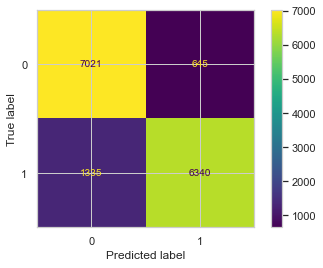

In [35]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, X_test, y_test)  

We note that we correctly predicted (7021 no-subscriptions / 6340 subscription) (87.09%) in our test set, while we incorrectly predicted 645 no-subscriptions (the model said it were subscriptions), and 1335 subscriptions (the model said it were no-subscriptions).

\
<b> Precision, recall, F-measure, and support</b>
    
From Scikit Learn official documentation, we have that:
- precision: the ability of the classifier to not label a sample as positive if it is negative, i.e., it is the ratio 
$$ $$
$$\frac{true\_positives}{true\_positives + false\_positives} $$
$ $
- recall: the ability of the classifier to find all the positive samples (value 1), i.e., it is the ratio 
$$ $$
$$\frac{true\_positives}{true\_positives + false\_negatives}$$
$ $
- F-measure: (or F-beta score) is a harmonic mean of precision and recall, for which the best value is 1. The F-beta score weights recall more than precision by a factor $\beta$. If $\beta = 1$, then recall and precision are equally weighted
- Support: number of occurrences of each class (0/1) in y_test

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7666
           1       0.91      0.83      0.86      7675

    accuracy                           0.87     15341
   macro avg       0.87      0.87      0.87     15341
weighted avg       0.87      0.87      0.87     15341



Notice that the definitions of both precision and recall are analogous for true_negatives.\
Moreover:
- Accuracy: 87% of times, the model predicted correctly both subscriptions and no-subscriptions. In our context, of the entire test set, 87% of the promoted term deposits were the term deposits that customers liked.
- Macro avg: averaging the unweighted mean per label (subscrip / no-subscrip). Unweighted here means assign equal (0.5) weights to each label. Since our sample is balanced, macro avg is basically equal to weighted avg.
- Weighted avg: averaging the support-weighted mean per label (subscrip / no-subscrip). We can see that the weight (support) for no-subs is 0.4997 (7666/15341), and for subs is 0.5003 (7675/15341).

\
<b>ROC Curve</b>

The receiver operating characteristic (ROC) curve is another tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier, while our model is represented by the blue line. The idea is that a good classifier is as close as possible to the top-left corner.\
Another way to understand the graph is the area under the ROC curve (AUC). It is just the area under the blue line of our graph. When this area equals 1 (whole square), we have a perfect classifier.

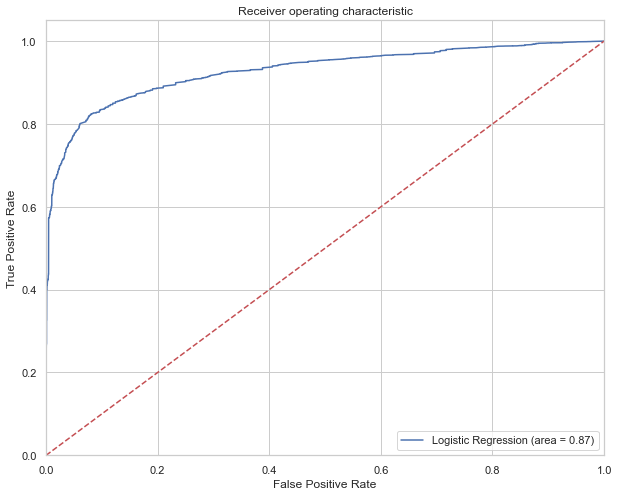

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

The y axis is a synonym for recall. The x axis is the following rate
$$\frac{false\_positives}{false\_positives + true\_negatives}.$$
\
This rate show the ability of the classifier to find all negative samples (value 0). We want $false\_positives = 0 \Rightarrow FPR = 0$. \
The ROC curve plots TPR v. FPR at different classification thresholds. It shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). We always want a TPR closer to 1 and a FPR closer to zero (top-left corner).